In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
df = pd.read_csv("../data/processed/df_raw_cleaned.csv")
df.head()

,valeur,Latitude,Longitude,date,hour,day,month,year,weekday,weekend,pollutant_encoded,influence_encoded,evaluation_encoded,implantation_encoded,site_encoded,lag_1,lag_24,rolling_3
0,2.0,43.486234,5.171939,2025-01-01 00:00:00,0,1,1,2025,2,0,2,0,0,0,0,58.8,24.7,14.033333
1,35.8,43.416661,5.042731,2025-01-01 00:00:00,0,1,1,2025,2,0,2,0,0,4,1,25.2,3.2,25.333333
2,6.7,43.506149,4.982898,2025-01-01 00:00:00,0,1,1,2025,2,0,2,0,0,4,4,30.7,21.0,14.833333
3,0.9,43.675114,4.629210,2025-01-01 00:00:00,0,1,1,2025,2,0,2,0,0,4,8,66.5,42.0,14.466667
4,37.6,43.437874,6.768390,2025-01-01 00:00:00,0,1,1,2025,2,0,3,0,0,0,26,38.3,65.9,34.100000


In [14]:
df.columns

Index(['valeur', 'Latitude', 'Longitude', 'date', 'hour', 'day', 'month',
       'year', 'weekday', 'weekend', 'pollutant_encoded', 'influence_encoded',
       'evaluation_encoded', 'implantation_encoded', 'site_encoded', 'lag_1',
       'lag_24', 'rolling_3'],
      dtype='object')

In [15]:
# choose one pollutant and one site to start
pollutant_id = df["pollutant_encoded"].unique()[0]
site_id      = df["site_encoded"].unique()[0]
df_seq = df[
    (df["pollutant_encoded"] == pollutant_id) &
    (df["site_encoded"] == site_id)
].sort_values("date").reset_index(drop=True)

df_seq.head(), df_seq.shape


(   valeur   Latitude  Longitude                 date  hour  day  month  year  \
 0     2.0  43.486234   5.171939  2025-01-01 00:00:00     0    1      1  2025   
 1     2.3  43.486234   5.171939  2025-01-01 01:00:00     1    1      1  2025   
 2     2.1  43.486234   5.171939  2025-01-01 02:00:00     2    1      1  2025   
 3     1.9  43.486234   5.171939  2025-01-01 03:00:00     3    1      1  2025   
 4     1.7  43.486234   5.171939  2025-01-01 04:00:00     4    1      1  2025   
 
    weekday  weekend  pollutant_encoded  influence_encoded  evaluation_encoded  \
 0        2        0                  2                  0                   0   
 1        2        0                  2                  0                   0   
 2        2        0                  2                  0                   0   
 3        2        0                  2                  0                   0   
 4        2        0                  2                  0                   0   
 
    implantation_e

In [16]:
feature_cols = [
    "Latitude", "Longitude",
    "hour", "day", "month", "year",
    "weekday", "weekend",
    "pollutant_encoded", "influence_encoded",
    "evaluation_encoded", "implantation_encoded",
    "site_encoded",
    "lag_1", "lag_24", "rolling_3"
]

target_col = "valeur"   # we’ll predict actual pollution level

In [17]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

X_raw = df_seq[feature_cols].values
y_raw = df_seq[target_col].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)

def create_sequences(X, y, window_size=24):
    Xs, ys = [], []
    for i in range(window_size, len(X)):
        Xs.append(X[i-window_size:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

window_size = 24  # last 24 hours -> predict next hour
X_seq, y_seq = create_sequences(X_scaled, y_raw, window_size)

print("X_seq shape:", X_seq.shape)  # (samples, 24, num_features)
print("y_seq shape:", y_seq.shape)  # (samples,)


X_seq shape: (7229, 24, 16)
y_seq shape: (7229,)


In [18]:
split_idx = int(len(X_seq) * 0.8)

X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

X_train.shape, X_test.shape


((5783, 24, 16), (1446, 24, 16))

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    
    LSTM(32),
    Dropout(0.2),

    Dense(16, activation="relu"),
    Dense(1)  # output pollution level
])

model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
model.summary()


c:\Users\njaya\anaconda3\envs\airquality-ml\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,697 (131.63 KB)

 Trainable params: 33,697 (131.63 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 4248.7192 - val_loss: 1747.9318
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1617.0988 - val_loss: 571.0519
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1033.4761 - val_loss: 579.0401
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1038.7350 - val_loss: 576.4240
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1034.3920 - val_loss: 585.2870
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1035.2939 - val_loss: 577.3018
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1028.0730 - val_loss: 573.3510
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1024.2990 - val_loss: 582.4308
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1036.1663 - val_loss: 576.7813
Epoch 10/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1032.3771 - val_loss: 588.7280
Epoch 11/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1036.9562 - val_

In [21]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("RMSE:", rmse)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
MAE: 11.593864351354364
RMSE: 14.808822305230214


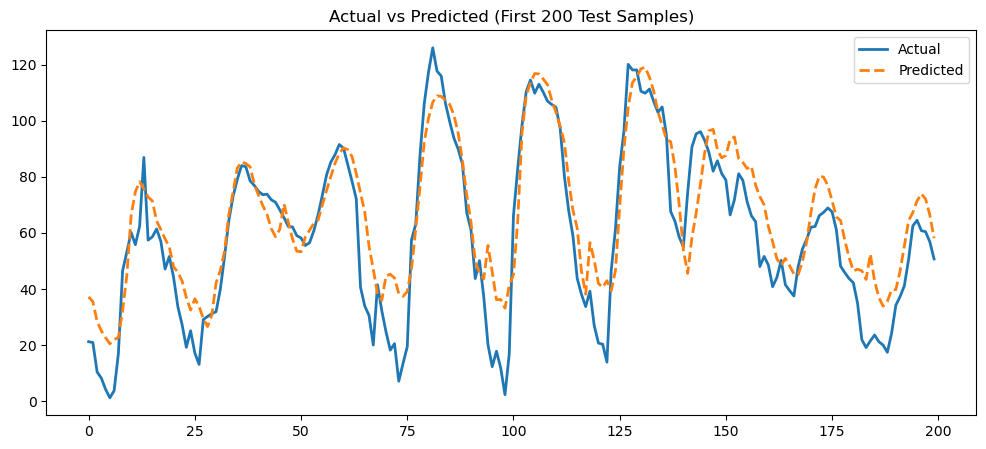

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test[:200], label="Actual", linewidth=2)
plt.plot(y_pred[:200], label="Predicted", linestyle="--", linewidth=2)
plt.legend()
plt.title("Actual vs Predicted (First 200 Test Samples)")
plt.show()


In [23]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
y_pred = model.predict(X_test).ravel()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²  : {r2:.4f}")


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 200.7899 - val_loss: 117.5360
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 192.4191 - val_loss: 106.3953
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 187.0107 - val_loss: 103.1067
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 180.4101 - val_loss: 98.2753
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 178.5655 - val_loss: 93.3680
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 177.7543 - val_loss: 99.6006
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 172.8843 - val_loss: 97.9469
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 171.9765 - val_loss: 100.0222
Epoch 9/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 170.0997 - val_loss: 99.4699
Epoch 10/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 168.8172 - val_loss: 92.6450
Epoch 11/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 166.9918 - val_loss: 111.7409
Epo